In [7]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Lambda, Conv2D
from keras.layers import GlobalAveragePooling2D, Input, Dropout
from keras.layers.convolutional import MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, SGD
import numpy as np
import urllib


path = '/home/auv/Sahil/dogs-vs-cats/'
model_path = 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'
target_size=(224, 224)
batch_size=32

def preprocess_image(im):
    vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
    #im = cv2.resize(cv2.imread(path), (224, 224)).astype(np.float32)
    im = (im - vgg_mean)
    return im[:, ::-1] # RGB to BGR

def create_vgg16(x=None):
    # we initialize the model
    model = Sequential()

    # Conv Block 1
    model.add(Lambda(preprocess_image, input_shape=(224,224,3), output_shape=(224,224,3)))

    model.add(Conv2D(64, (3, 3), input_shape=(224,224,3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Conv Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Conv Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Conv Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Conv Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # FC layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1000, activation='softmax'))

    return model


def get_batches(directory, target_size=target_size, batch_size=batch_size, shuffle=False):
    datagen = ImageDataGenerator()
    return datagen.flow_from_directory(directory=directory,
                                          target_size=target_size,
                                          batch_size=batch_size,
                                          class_mode="categorical",
                                          shuffle=shuffle)
  

In [8]:
batches = get_batches(path+'train', shuffle=True)
valid_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)


initial_model = create_vgg16()

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [84]:
initial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 56, 56, 256)       295168    
__________

In [9]:
initial_model.load_weights(model_path, by_name=True)

x = Dense(batches.num_classes, activation='softmax')(initial_model.layers[-2].output)
adam_model = Model(initial_model.input, x)
#adam_model = initial_model

In [15]:
def lr_schedule(epoch):
    if epoch < 5:
        return 0.0001
    else:
        return 0.00001

In [12]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger, TensorBoard


In [16]:

for layer in initial_model.layers: layer.trainable=False
# previous issue of keras
# when adding a `Model` or `Sequential` as the **first layer** in a `Sequential` model,
# the `Sequential` model will use the preexisting input and output of the model/sequential
# without calling the model/sequential on a new `Input`.

# What that means is that the `conv_base.trainable = False` is ineffective, because `model`
# doesn't see `conv_base` itself, it sees all its inner layers instead.

csv_logger = CSVLogger(filename='sgd_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)



callbacks = [csv_logger,
             learning_rate_scheduler]

opt = Adam(lr=0.001)
adam_model.compile(optimizer=opt,
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = adam_model.fit_generator(batches,
                                   steps_per_epoch=batches.samples//batch_size,
                                   epochs=10,
                                   callbacks=callbacks,
                validation_data=valid_batches,
                                   validation_steps=valid_batches.samples//batch_size)


Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
703/703 [==============================] - 107s 153ms/step - loss: 0.6782 - acc: 0.5814 - val_loss: 0.6676 - val_acc: 0.6160
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
703/703 [==============================] - 108s 154ms/step - loss: 0.6635 - acc: 0.6124 - val_loss: 0.6575 - val_acc: 0.6303
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
703/703 [==============================] - 106s 151ms/step - loss: 0.6540 - acc: 0.6262 - val_loss: 0.6483 - val_acc: 0.6455
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
703/703 [==============================] - 109s 156ms/step - loss: 0.6473 - acc: 0.6373 - val_loss: 0.6450 - val_acc: 0.6342
Epoch 5/10

Epoch 00005: LearningRateScheduler setting learning rate to 0.0001.
703/703 [==============================] - 108s 153ms/step - loss: 0.6418 - acc: 0.6434 - val_loss: 

In [68]:
adam_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 56, 56, 256)       295168    
__________

In [5]:
from matplotlib import pyplot as plt 

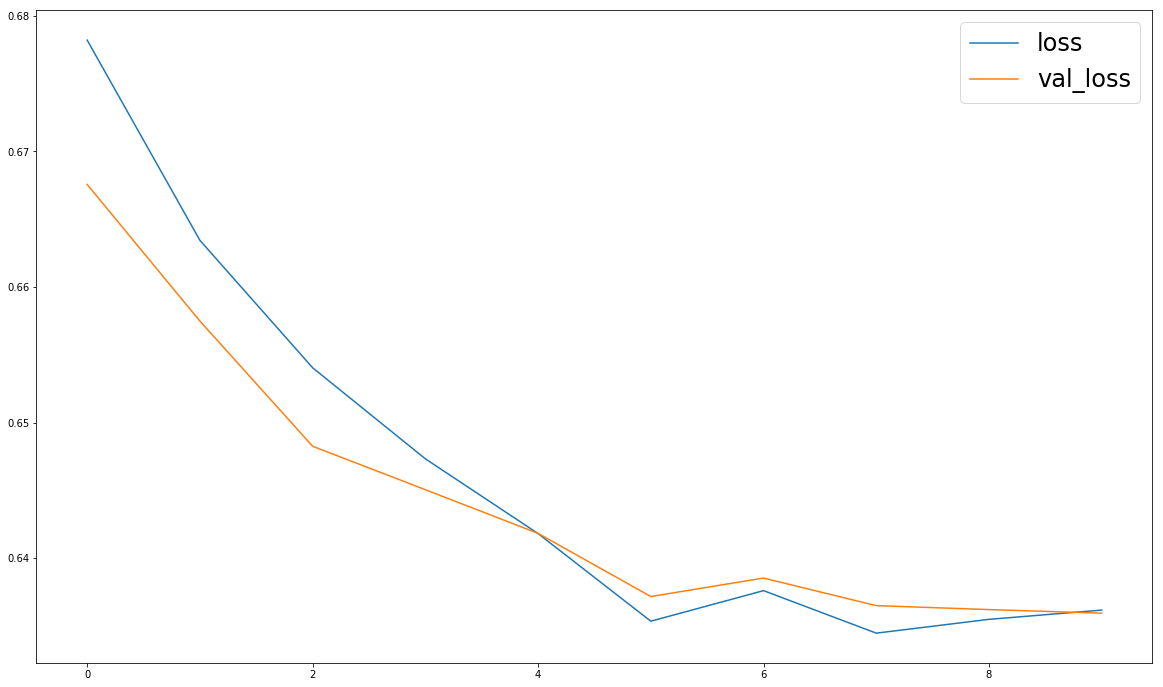

In [17]:
# the second time I ran adam with lr=0.0001, 0.00001
plt.figure(figsize=(20,12))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});

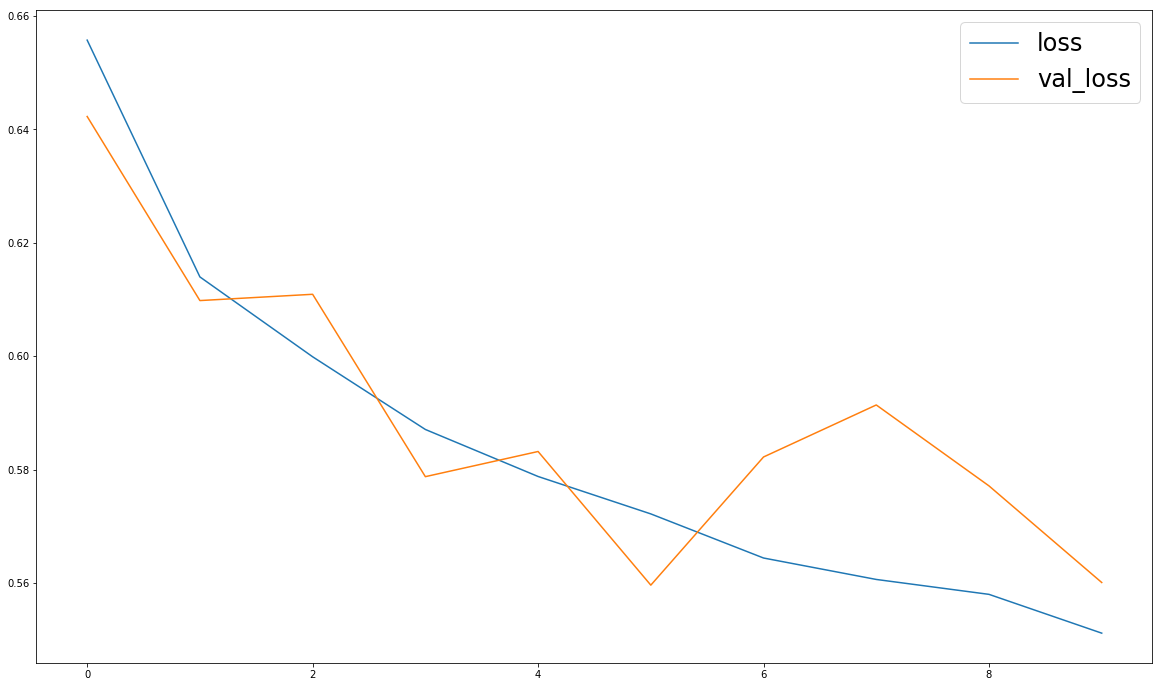

In [6]:
# the second time I ran adam with lr=0.001
plt.figure(figsize=(20,12))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});

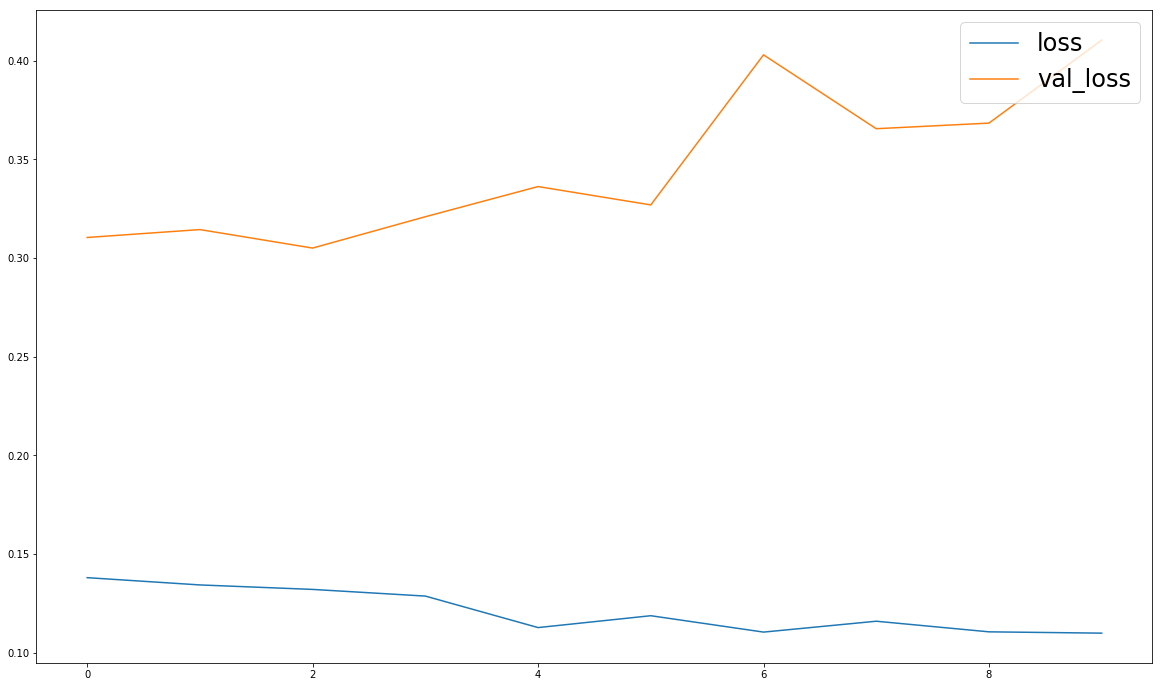

In [7]:
# the first time I ran adam with lr=0.001 with preprocessing
plt.figure(figsize=(20,12))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});

In [18]:
sgd_model = Model(initial_model.input, x)

csv_logger = CSVLogger(filename='sgd_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)



callbacks = [csv_logger,
             learning_rate_scheduler]

opt = SGD(lr=0.001)
sgd_model.compile(optimizer=opt,
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

sgd_history = sgd_model.fit_generator(batches, 
                                      steps_per_epoch=batches.samples//batch_size,
                                      epochs=10,
                                      callbacks=callbacks,
                                      validation_data=valid_batches,
                                      validation_steps=valid_batches.samples//batch_size)

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
703/703 [==============================] - 106s 151ms/step - loss: 0.6339 - acc: 0.6576 - val_loss: 0.6350 - val_acc: 0.6609
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
703/703 [==============================] - 107s 152ms/step - loss: 0.6346 - acc: 0.6579 - val_loss: 0.6355 - val_acc: 0.6573
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
703/703 [==============================] - 107s 152ms/step - loss: 0.6343 - acc: 0.6543 - val_loss: 0.6366 - val_acc: 0.6580
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
703/703 [==============================] - 106s 151ms/step - loss: 0.6326 - acc: 0.6588 - val_loss: 0.6352 - val_acc: 0.6589
Epoch 5/10

Epoch 00005: LearningRateScheduler setting learning rate to 0.0001.
703/703 [==============================] - 107s 152ms/step - loss: 0.6353 - acc: 0.6549 - val_loss: 

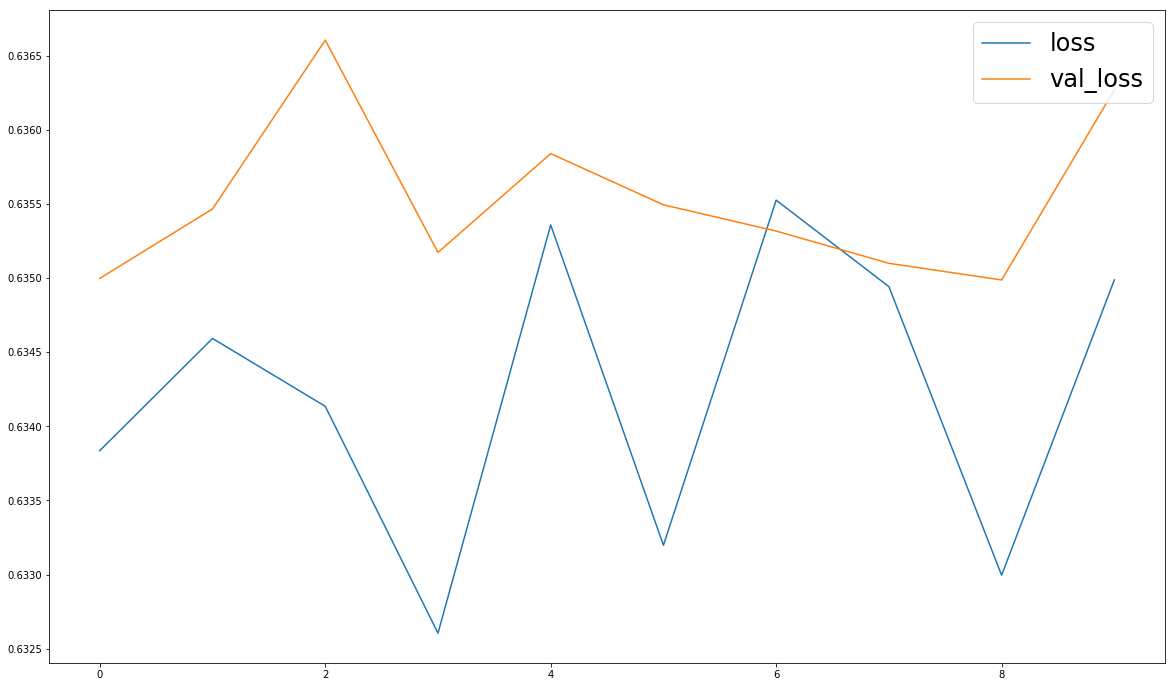

In [19]:
# the first time I ran sgd with lr=0.0001 and lr=0.00001
plt.figure(figsize=(20,12))
plt.plot(sgd_history.history['loss'], label='loss')
plt.plot(sgd_history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});

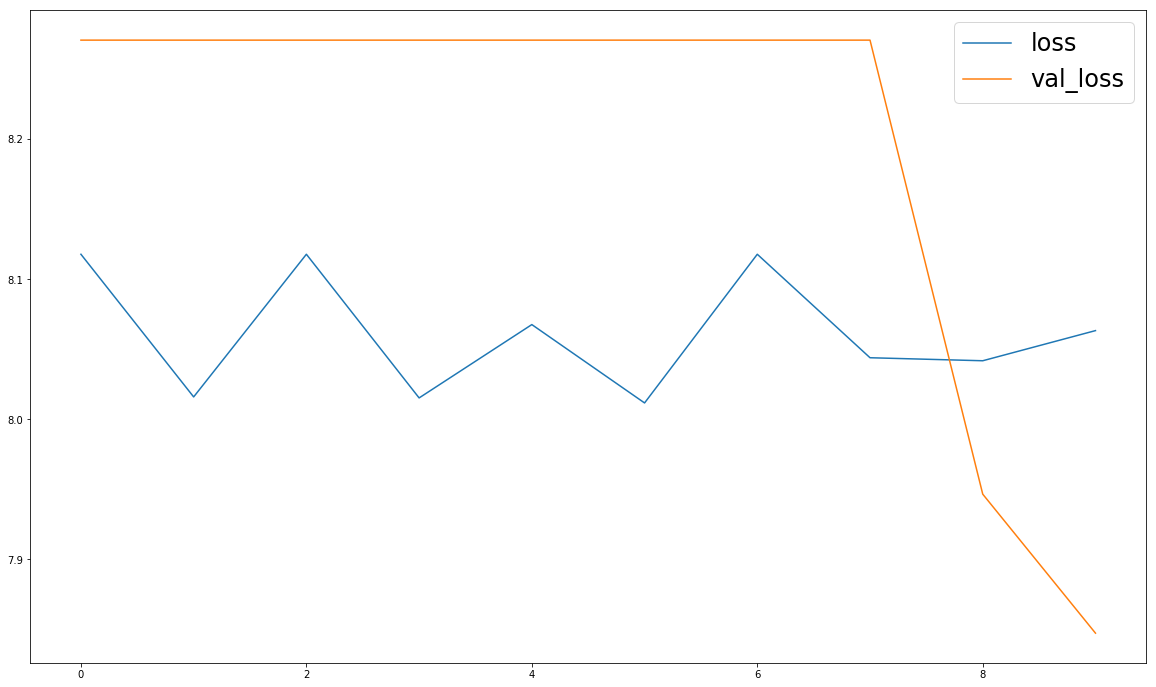

In [11]:
# the first time I ran sgd with lr=0.001
plt.figure(figsize=(20,12))
plt.plot(sgd_history.history['loss'], label='loss')
plt.plot(sgd_history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});

In [12]:
rmsprop_model = Model(initial_model.input, x)

opt = RMSprop(lr=0.001)
rmsprop_model.compile(optimizer=opt,
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

rmsprop_history = rmsprop_model.fit_generator(batches, steps_per_epoch=batches.samples//batch_size, epochs=10,
                validation_data=valid_batches, validation_steps=valid_batches.samples//batch_size)



Epoch 1/10
703/703 [==============================] - 197s 281ms/step - loss: 8.0906 - acc: 0.4980 - val_loss: 8.2708 - val_acc: 0.4869
Epoch 2/10
703/703 [==============================] - 196s 279ms/step - loss: 8.0490 - acc: 0.5006 - val_loss: 8.2708 - val_acc: 0.4869
Epoch 3/10
703/703 [==============================] - 196s 278ms/step - loss: 8.0261 - acc: 0.5020 - val_loss: 8.2708 - val_acc: 0.4869
Epoch 4/10
703/703 [==============================] - 196s 279ms/step - loss: 8.1171 - acc: 0.4964 - val_loss: 8.1583 - val_acc: 0.4938
Epoch 5/10
703/703 [==============================] - 197s 280ms/step - loss: 8.0297 - acc: 0.5018 - val_loss: 7.8473 - val_acc: 0.5131
Epoch 6/10
703/703 [==============================] - 197s 280ms/step - loss: 8.0340 - acc: 0.5016 - val_loss: 7.8473 - val_acc: 0.5131
Epoch 7/10
703/703 [==============================] - 196s 279ms/step - loss: 8.0920 - acc: 0.4980 - val_loss: 7.8473 - val_acc: 0.5131
Epoch 8/10
703/703 [============================

In [ ]:
# the first time I ran sgd with lr=0.0001 and lr=0.00001
plt.figure(figsize=(20,12))
plt.plot(sgd_history.history['loss'], label='loss')
plt.plot(sgd_history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});

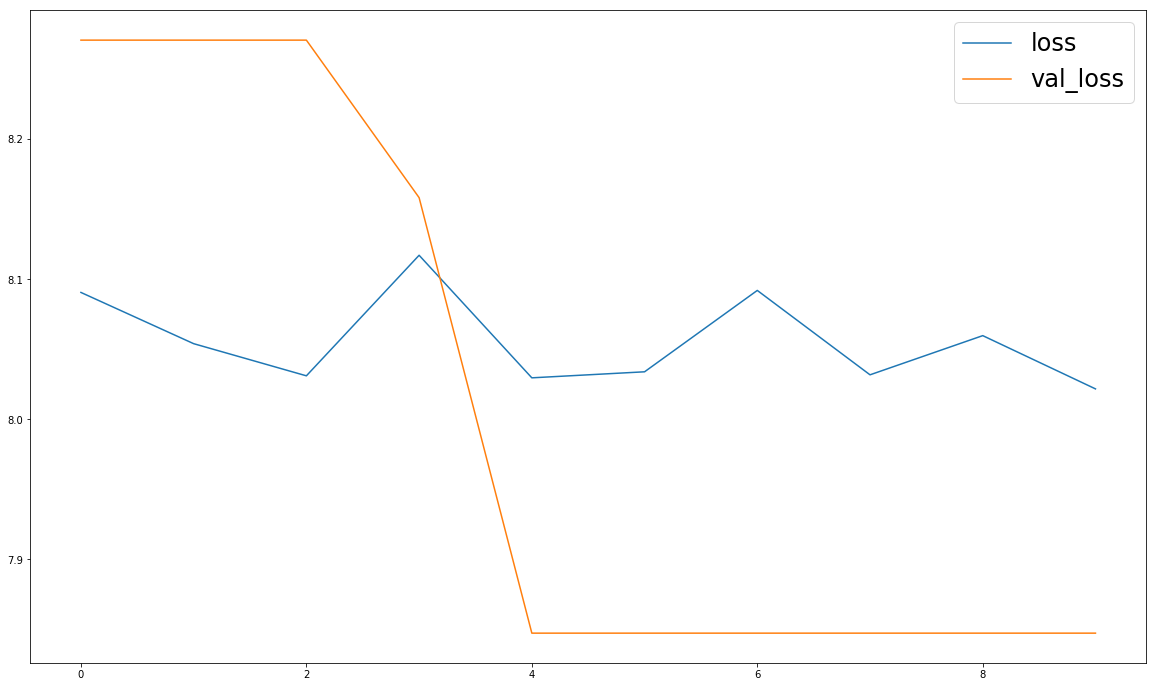

In [13]:
# the first time I ran rmsprop with lr=0.001
plt.figure(figsize=(20,12))
plt.plot(rmsprop_history.history['loss'], label='loss')
plt.plot(rmsprop_history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});

In [ ]:
###############################################################
###############################################################
#################  VISUALIZATION ##############################
###############################################################
###############################################################

In [106]:
img_path = path+'test1/19.jpg'
from keras.preprocessing import image
img = image.load_img(img_path, target_size=(224,224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

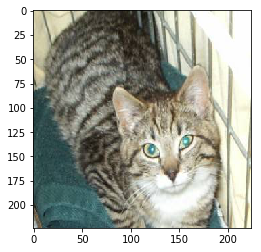

(1, 224, 224, 3)


In [107]:
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

print(img_tensor.shape)

In [64]:
adam_model.predict(img_tensor)


array([[1., 0.]], dtype=float32)

In [18]:
layer_outputs = [layer.output for layer in adam_model.layers[:20]]

In [19]:
activation_model = Model(inputs=adam_model.input, outputs=layer_outputs)

In [20]:
activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1_input (InputLayer)  (None, 224, 224, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
__________

In [94]:
img_tensor = preprocess_input(img_tensor)
activations = activation_model.predict(img_tensor)

InvalidArgumentError: lambda_1_input:0 is both fed and fetched.

In [27]:
first_layer_activation = activations[0]

In [28]:
print(first_layer_activation.shape)

(1, 224, 224, 3)


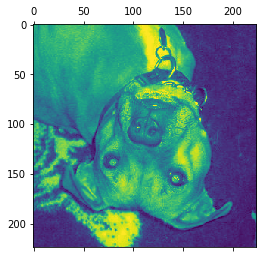

In [36]:
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

In [37]:
second_layer_activation = activations[1]

In [38]:
print(second_layer_activation.shape)

(1, 224, 224, 64)


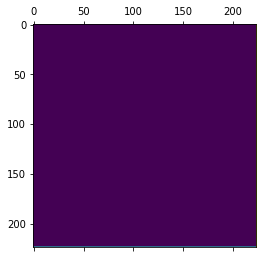

In [44]:
plt.matshow(second_layer_activation[0, :, :, 55], cmap='viridis')
# result of untrained model

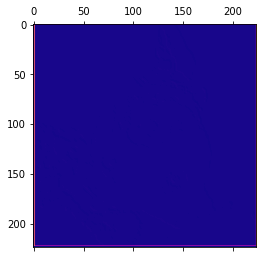

In [46]:
third_layer_activation = activations[2]
plt.matshow(third_layer_activation[0, :, :, 55], cmap='plasma')
# result of untrained model

In [93]:
#####################################################
########## Using a pre trained network ##############
#####################################################
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

pre_trained_model = VGG16(weights='imagenet', include_top=False)


In [96]:
features = pre_trained_model.predict(img_tensor)

In [99]:
layer_outputs = [layer.output for layer in pre_trained_model.layers[:19]] 

In [98]:
pre_trained_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [101]:
activation_model = Model(inputs=pre_trained_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [111]:
img_path = path+'test1/19.jpg'
from keras.preprocessing import image
img = image.load_img(img_path, target_size=(224,224))
img_tensor = image.img_to_array(img)
img_tensor = img_tensor.reshape((1, img_tensor.shape[0], img_tensor.shape[1], img_tensor.shape[2]))
img_tensor = preprocess_input(img_tensor)
activations = activation_model.predict(img_tensor)

InvalidArgumentError: input_2:0 is both fed and fetched.